## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Split dataset
> test-train leakage를 최소화하기위해 feature selection 전에 data split을 함

In [2]:
# load data and define x and y
df = pd.read_csv('df_mod.csv')
y = df[' Label']
X = df.drop([' Label'], axis = 1)

In [3]:
# selecting features using all data before splitting into folds cause train-test leakage
# split dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,test_size = 0.3, random_state=10)

#train.describe()
#test.describe()

# Packet Attack Distribution
display(train[' Label'].value_counts())
display(test[' Label'].value_counts())

BENIGN                        1590168
DoS Hulk                       161041
PortScan                       110877
DDoS                            89672
DoS GoldenEye                    7218
FTP-Patator                      5597
SSH-Patator                      4139
DoS slowloris                    4006
DoS Slowhttptest                 3867
Bot                              1396
Web Attack � Brute Force         1020
Web Attack � XSS                  456
Infiltration                       25
Web Attack � Sql Injection         20
Heartbleed                         11
Name:  Label, dtype: int64

BENIGN                        681152
DoS Hulk                       69083
PortScan                       47927
DDoS                           38353
DoS GoldenEye                   3075
FTP-Patator                     2338
DoS slowloris                   1790
SSH-Patator                     1758
DoS Slowhttptest                1632
Bot                              560
Web Attack � Brute Force         487
Web Attack � XSS                 196
Infiltration                      11
Web Attack � Sql Injection         1
Name:  Label, dtype: int64

## Standarziation
> numerical atrribute를 standardize함

In [4]:
# scale numerical attributes
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [5]:
# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 

# creating one hot encoder object 
onehotencoder = OneHotEncoder() 

trainDep = train[' Label'].values.reshape(-1,1)
trainDep = onehotencoder.fit_transform(trainDep).toarray()
testDep = test[' Label'].values.reshape(-1,1)
testDep = onehotencoder.fit_transform(testDep).toarray()

In [6]:
train_X = sc_traindf
train_y = trainDep[:,0]

test_X = sc_testdf
test_y = testDep[:,0]

## Feature Selection - Filter
> Anova (F-value)를 이용해 K best feature를 선택

In [7]:
# use anova (f-value) to select k best features (filter)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

best_feat = SelectKBest(score_func = f_classif, k = 10)
fit = best_feat.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

feat_scores = pd.concat([df_columns, df_scores], axis=1)
feat_scores.columns = ['Specs', 'Score']
n = len(feat_scores['Specs'])//2  # halved
print(feat_scores.nlargest(n,'Score'))

feat = pd.DataFrame()
for i in feat_scores.nlargest(n,'Score')['Specs']:
        feat[i] = df[i]
        
feat[' Label'] = df[' Label']   
feat

                      Specs          Score
13    Bwd Packet Length Std  181341.601850
12   Bwd Packet Length Mean  168731.875404
54     Avg Bwd Segment Size  168731.875404
10    Bwd Packet Length Max  165610.391860
41        Packet Length Std  150604.095623
22              Fwd IAT Std  144393.522587
39        Max Packet Length  133035.203032
42   Packet Length Variance  130584.894611
77                 Idle Min  123266.951215
74                Idle Mean  122758.069390
52      Average Packet Size  119009.004421
40       Packet Length Mean  117098.080825
76                 Idle Max  116594.922659
18             Flow IAT Max  112690.459755
23              Fwd IAT Max  112384.279699
17             Flow IAT Std   75974.750164
46           PSH Flag Count   42558.610987
20            Fwd IAT Total   38113.122032
1             Flow Duration   37594.224079
43           FIN Flag Count   29611.935134
16            Flow IAT Mean   23262.008407
27              Bwd IAT Std   22340.707652
69     min_

,Bwd Packet Length Std,Bwd Packet Length Mean,Avg Bwd Segment Size,Bwd Packet Length Max,Packet Length Std,Fwd IAT Std,Max Packet Length,Packet Length Variance,Idle Min,Idle Mean,...,Flow IAT Min,Idle Std,Active Max,Init_Win_bytes_forward,Bwd IAT Mean,Active Std,Down/Up Ratio,Destination Port,URG Flag Count,Label
0,0.0,0.0,0.0,0,0.000000,0.000,6,0.00000,0,0.0,...,3,0.0,0,33,0.0,0.0,0,54865,0,BENIGN
1,0.0,6.0,6.0,6,0.000000,0.000,6,0.00000,0,0.0,...,109,0.0,0,29,0.0,0.0,1,55054,1,BENIGN
2,0.0,6.0,6.0,6,0.000000,0.000,6,0.00000,0,0.0,...,52,0.0,0,29,0.0,0.0,1,55055,1,BENIGN
3,0.0,6.0,6.0,6,0.000000,0.000,6,0.00000,0,0.0,...,34,0.0,0,31,0.0,0.0,1,46236,1,BENIGN
4,0.0,0.0,0.0,0,0.000000,0.000,6,0.00000,0,0.0,...,3,0.0,0,32,0.0,0.0,0,54863,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827871,0.0,76.0,76.0,76,23.421602,17755.844,76,548.57140,0,0.0,...,3,0.0,0,-1,3.0,0.0,0,53,0,BENIGN
2827872,0.0,181.0,181.0,181,76.133440,0.000,181,5796.30000,0,0.0,...,2,0.0,0,-1,2.0,0.0,1,53,0,BENIGN
2827873,0.0,6.0,6.0,6,16.350330,0.000,31,267.33334,0,0.0,...,4,0.0,0,1006,0.0,0.0,0,58030,0,BENIGN
2827874,0.0,128.0,128.0,128,42.332020,444210.060,128,1792.00000,0,0.0,...,1,0.0,0,-1,3.0,0.0,0,53,0,BENIGN


In [8]:
df_x = feat.copy().drop([' Label'], axis = 1)
#df_x.info()

<AxesSubplot:>

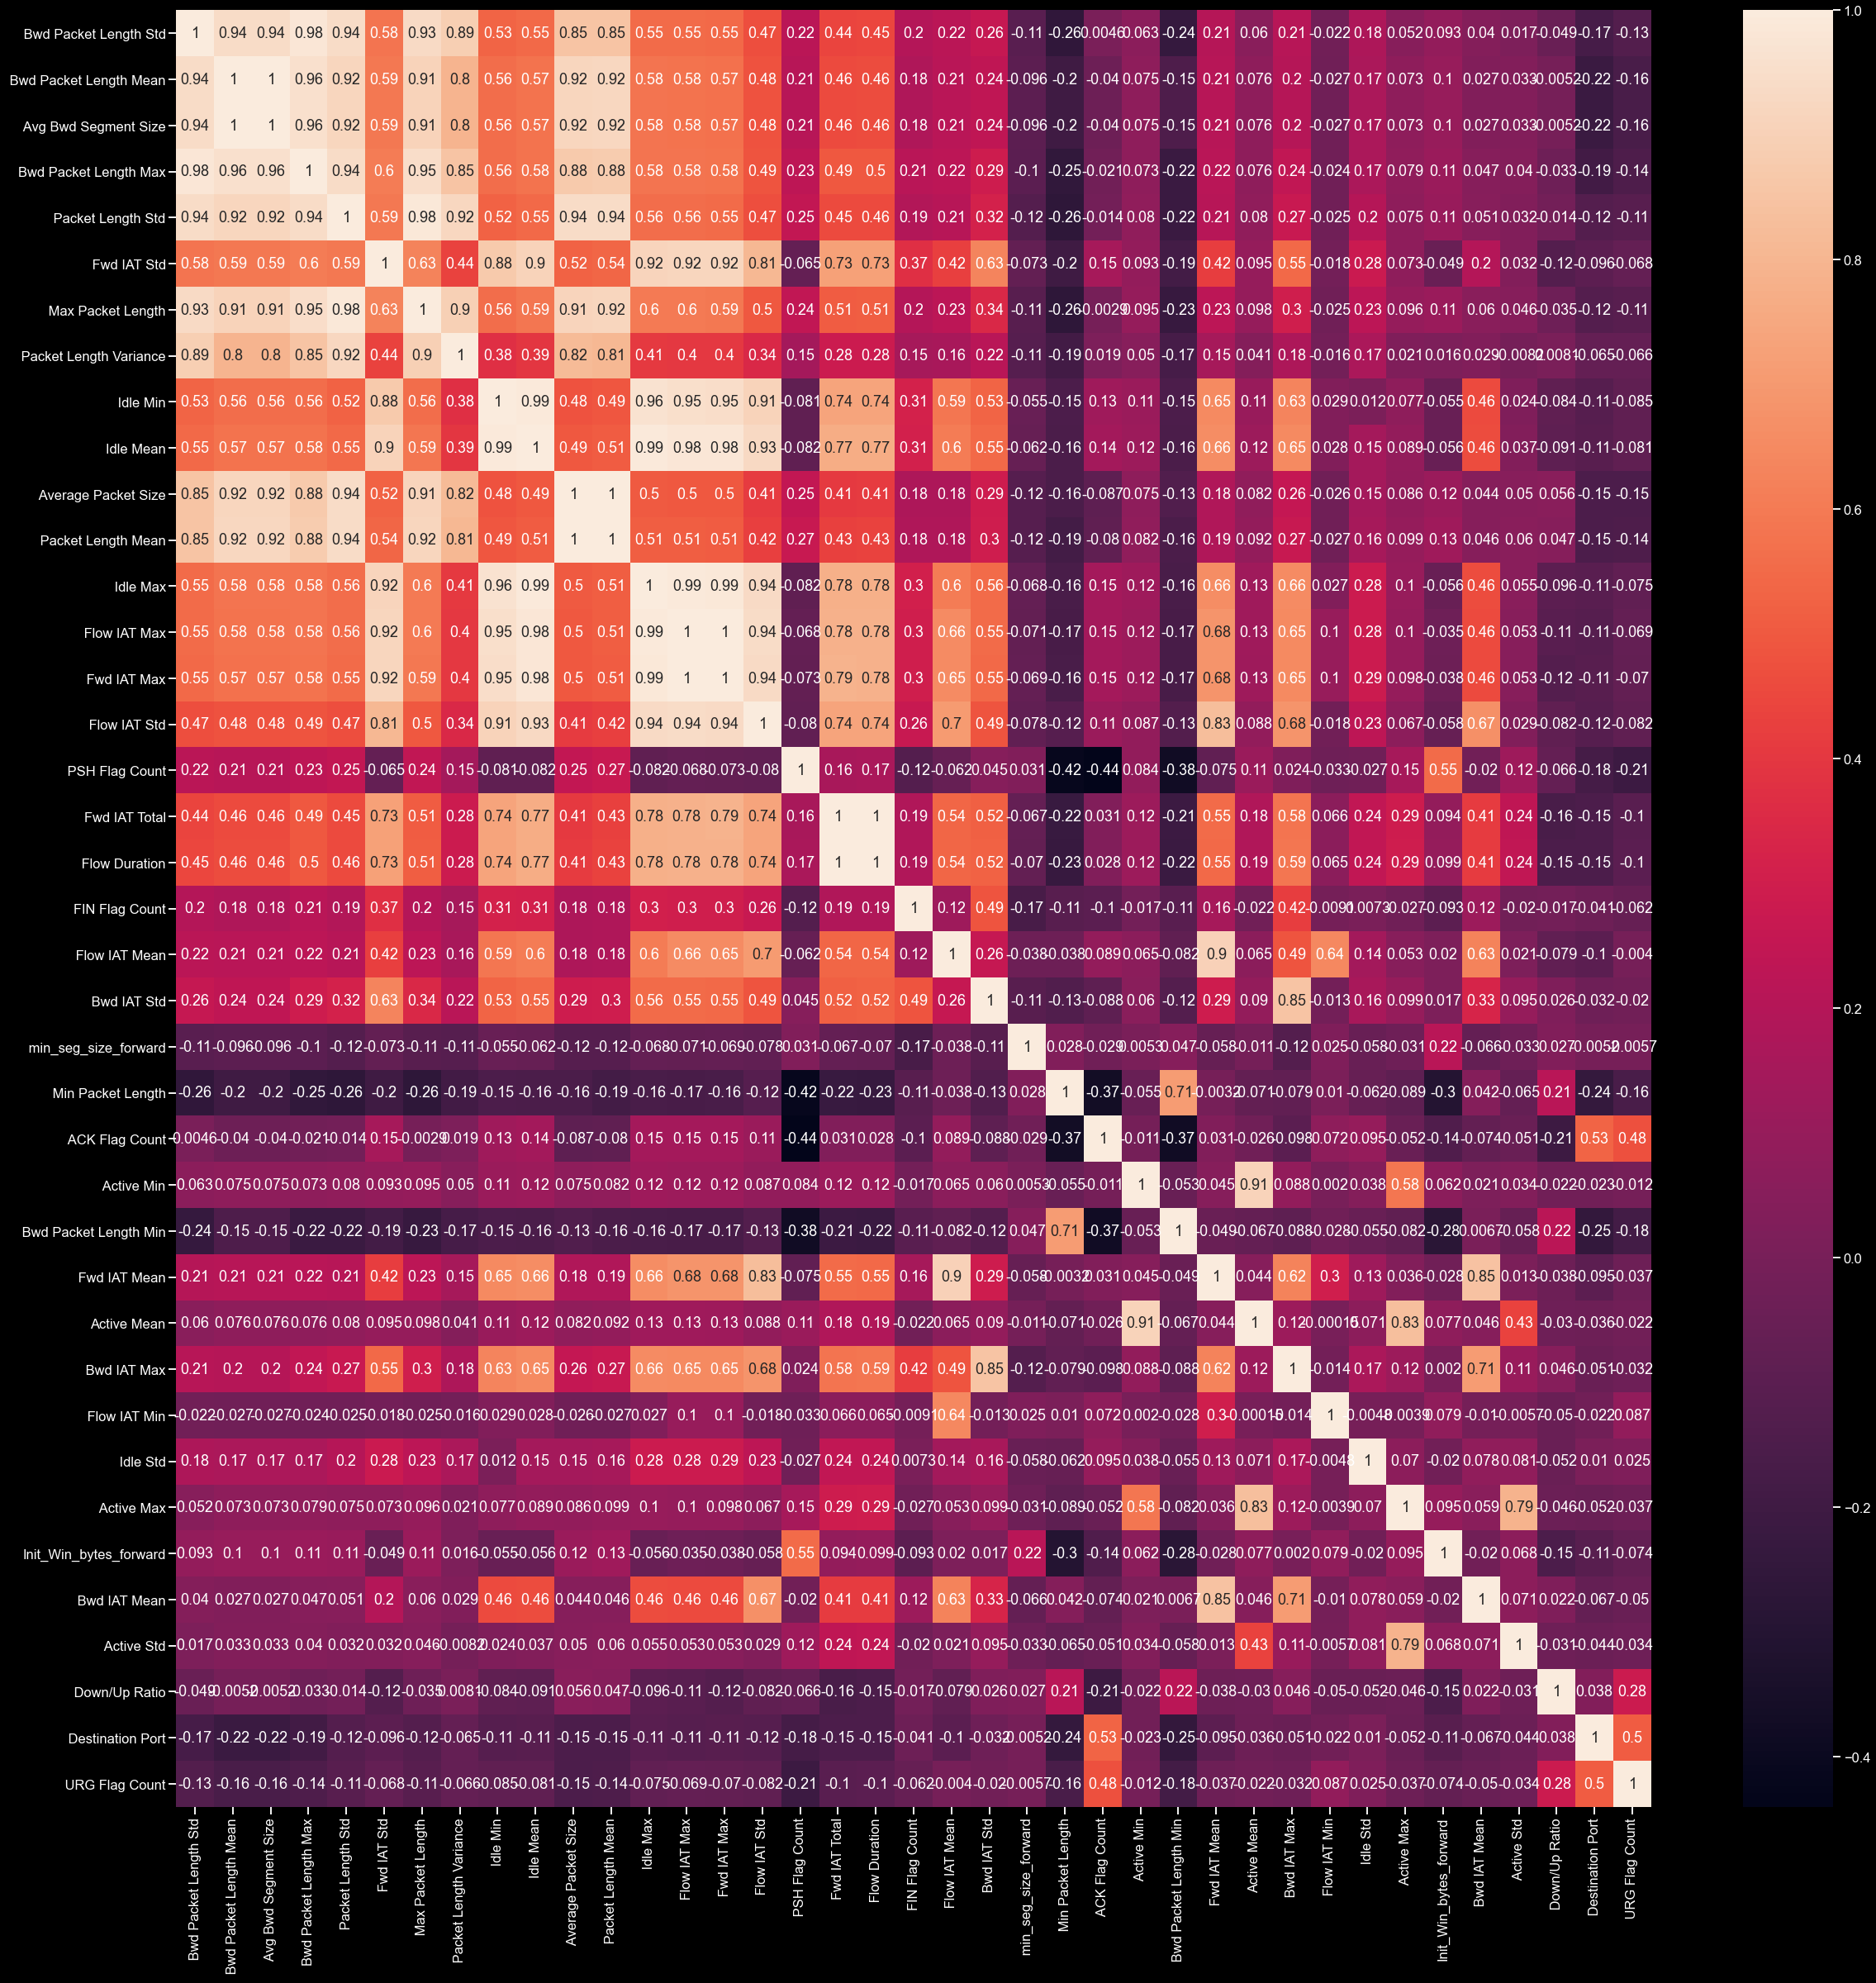

In [9]:
import seaborn as sns
# independent variable(독립변수)들 과의 correlation을 보기위해 heatmap 사용
# 밝은색일수록 높은 상관관계, 짙은색일수록 낮은 상관관계를 보여줌
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
fig = plt.figure(figsize=(40,40))
sns.heatmap(df_x.corr(), annot=True)

------ strong correlation <br>
bwd packet length std <br>
bwd packet length mean <br>
avg bwd segment size <br>
bwd packet length max <br>
packet length std <br>
max packet length <br>
packet length variance<br>
average packet size <br>
packet length mean <br>
------------- correlation <br>
Idle Min <br>
Idle Mean <br>
Idle max <br>
flow iat max <br>
fwd iat max <br>
Flow iat std <br>
Flow IAT Total --> 'Flow Duration'과 같아서 제거

In [10]:
# drop correlated features
df_x.drop([' Bwd Packet Length Mean'],axis=1,inplace=True)
df_x.drop([' Avg Bwd Segment Size'],axis=1,inplace=True)
df_x.drop(['Bwd Packet Length Max'],axis=1,inplace=True)
df_x.drop([' Packet Length Std'],axis=1,inplace=True)
df_x.drop([' Average Packet Size'],axis=1,inplace=True)
df_x.drop([' Packet Length Mean'],axis=1,inplace=True)
df_x.drop([' Max Packet Length'],axis=1,inplace=True)
df_x.drop([' Packet Length Variance'],axis=1,inplace=True)
df_x.drop([' Idle Min'],axis=1,inplace=True)
#df_x.drop(['Idle Mean'],axis=1,inplace=True)
df_x.drop([' Idle Max'],axis=1,inplace=True)
df_x.drop([' Flow IAT Max'],axis=1,inplace=True)
df_x.drop([' Fwd IAT Max'],axis=1,inplace=True)
df_x.drop([' Flow IAT Std'],axis=1,inplace=True)
df_x.drop(['Idle Mean'],axis=1,inplace=True)
df_x.drop(['Fwd IAT Total'],axis=1,inplace=True)

<AxesSubplot:>

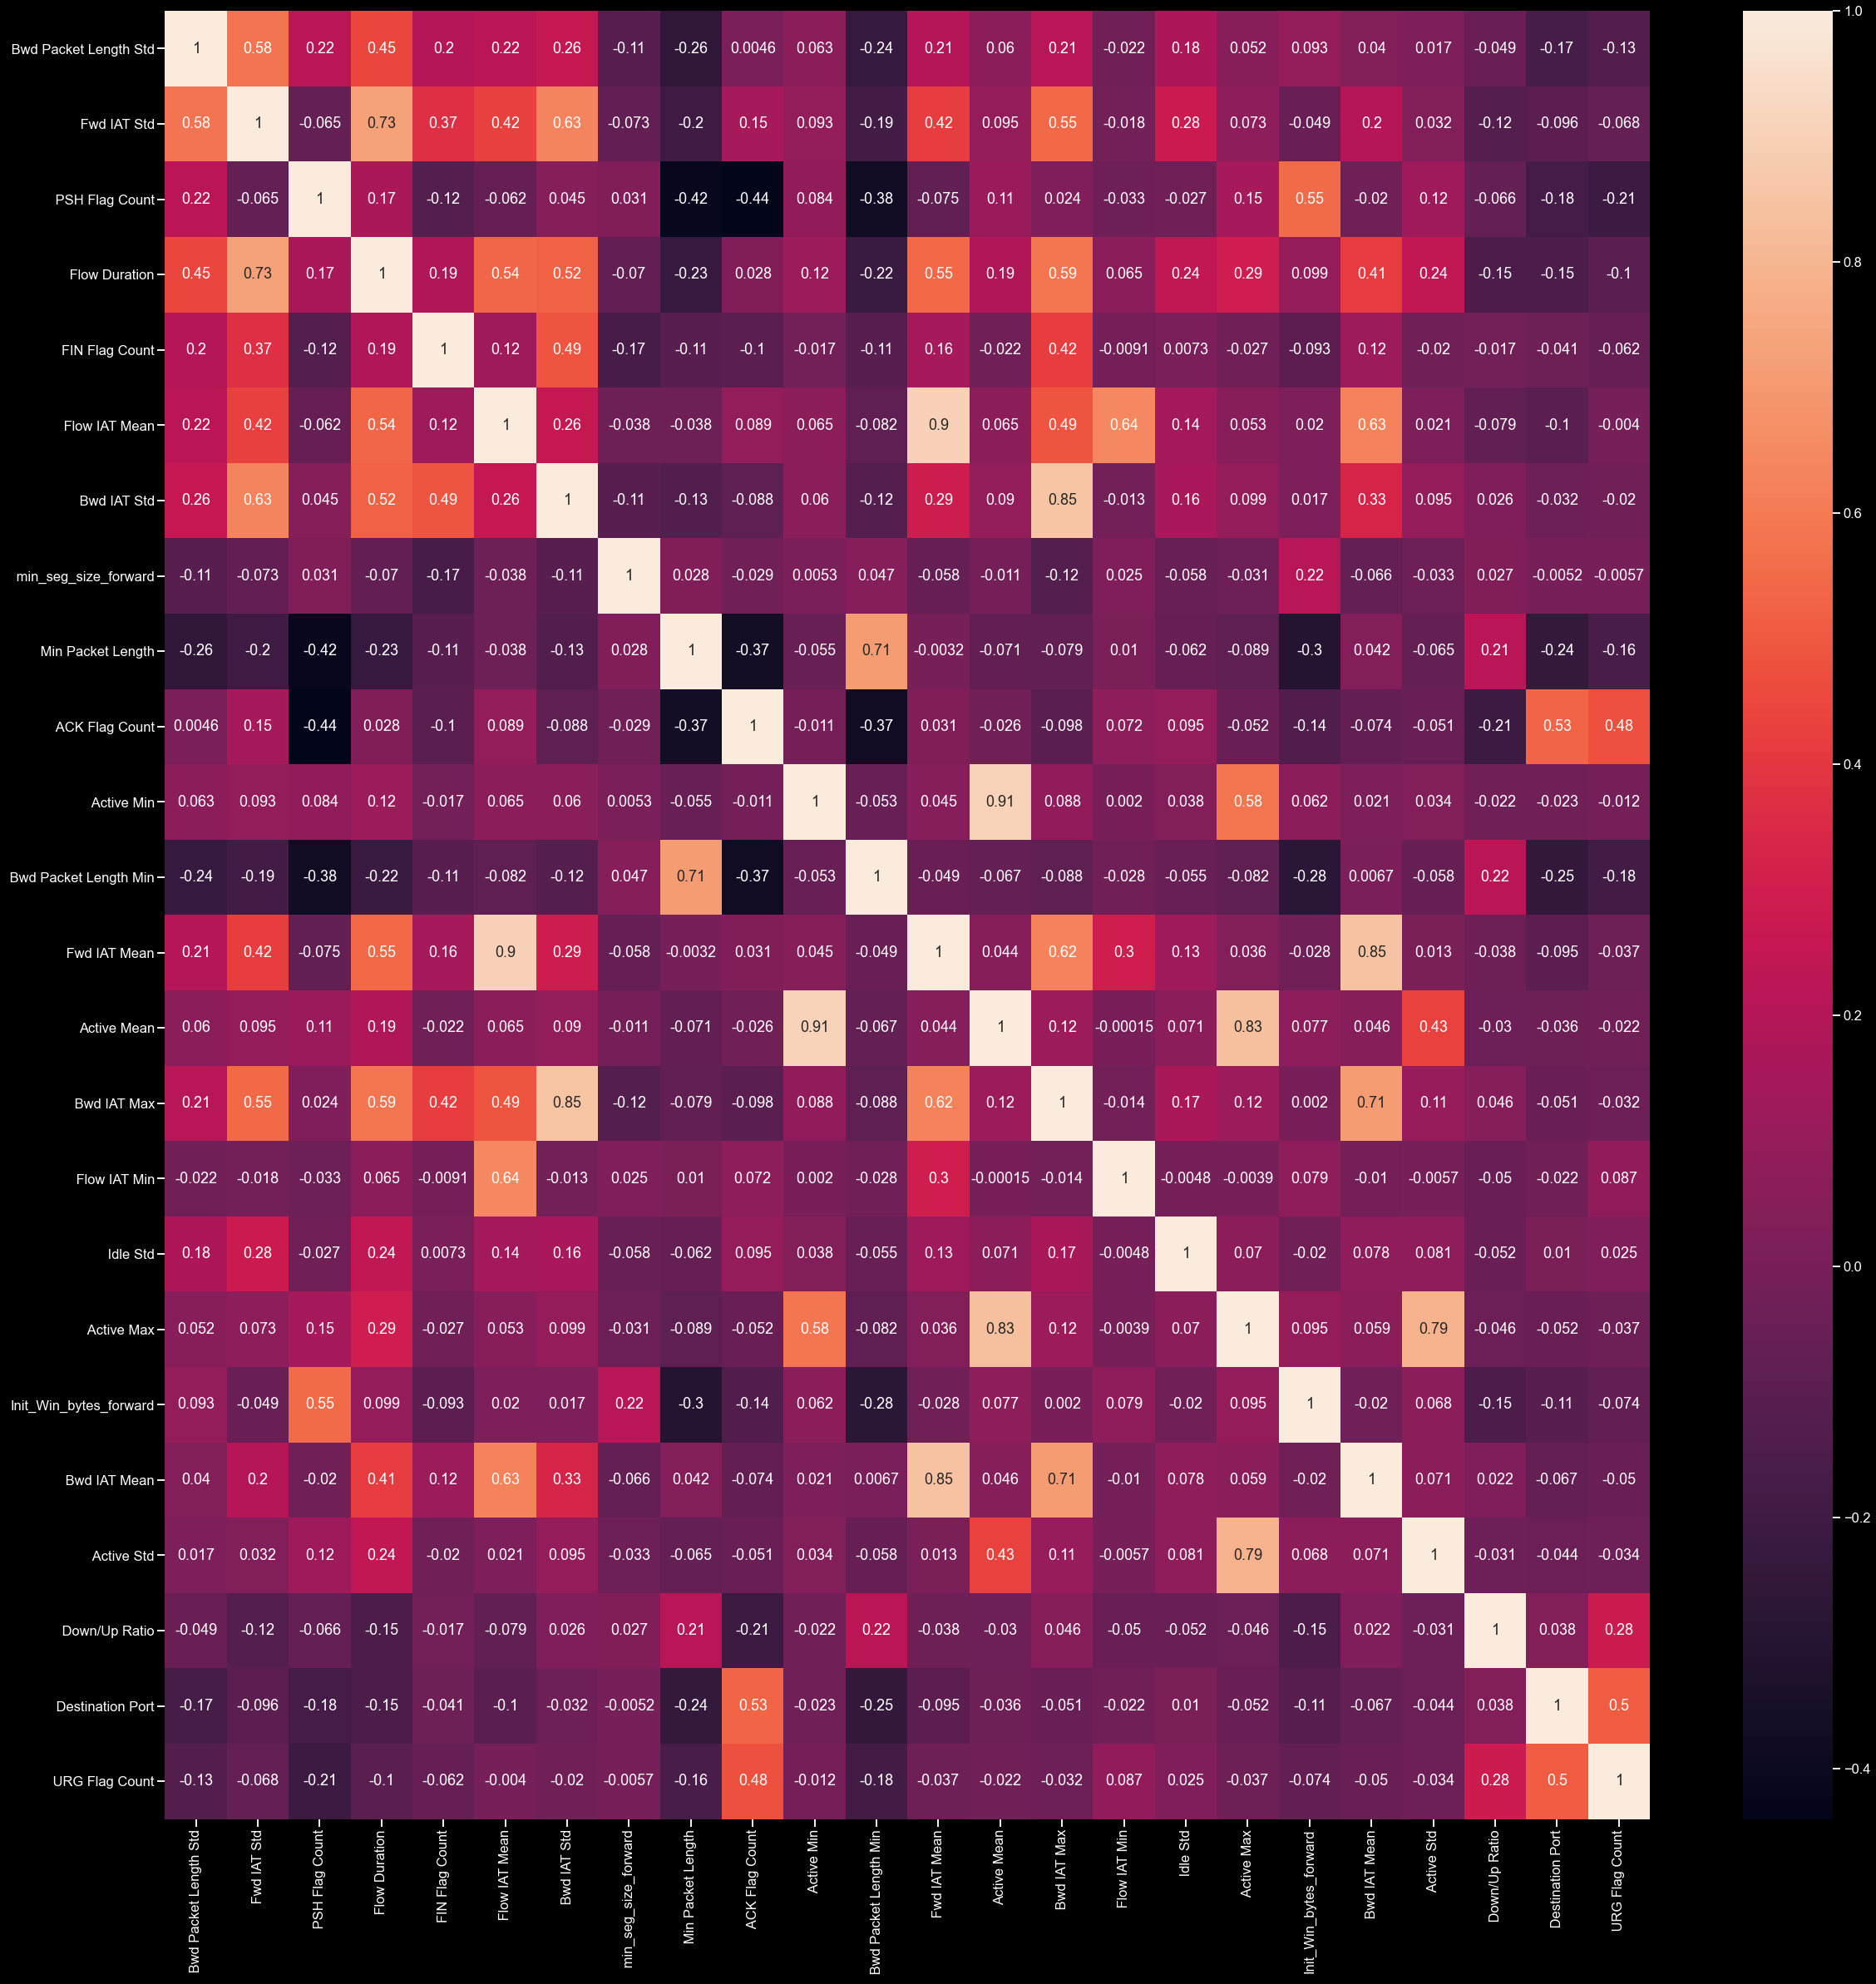

In [11]:
# heatmap w/t pre-selected features
fig = plt.figure(figsize=(40,40))
sns.heatmap(df_x.corr(),annot=True)

## Feature Selection - Embedded
> Lasso <br>
> Random Forest <br>
> Gradient Boosting <br>
> XGBoost

In [12]:
# Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

lr_lasso = SelectFromModel(LogisticRegression(penalty='l1',solver='liblinear'))
lasso_model = lr_lasso.fit(train_X,train_y)

lr_lasso_sup = lr_lasso.get_support()
lr_lasso_feat = train_X.loc[:,lr_lasso_sup].columns.tolist()
print(str(len(lr_lasso_feat)),'selected features')

70 selected features


In [13]:
#lr_lasso_feat

In [14]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=0)
gbc_model = gbc.fit(train_X,train_y)

train_score = gbc.score(train_X,train_y)
print('{:.3f}'.format(train_score))
test_score = gbc.score(test_X,test_y)
print('{:.3f}'.format(test_score))

# pruning
gbc_prnd = GradientBoostingClassifier(random_state=0,max_depth=1)
gbc_prnd_model = gbc_prnd.fit(train_X,train_y)

train_score_prnd = gbc_prnd.score(train_X,train_y)
print('{:.3f}'.format(train_score_prnd))
test_score_prnd = gbc_prnd.score(test_X,test_y)
print('{:.3f}'.format(test_score_prnd))

0.997
0.922
0.979
0.913


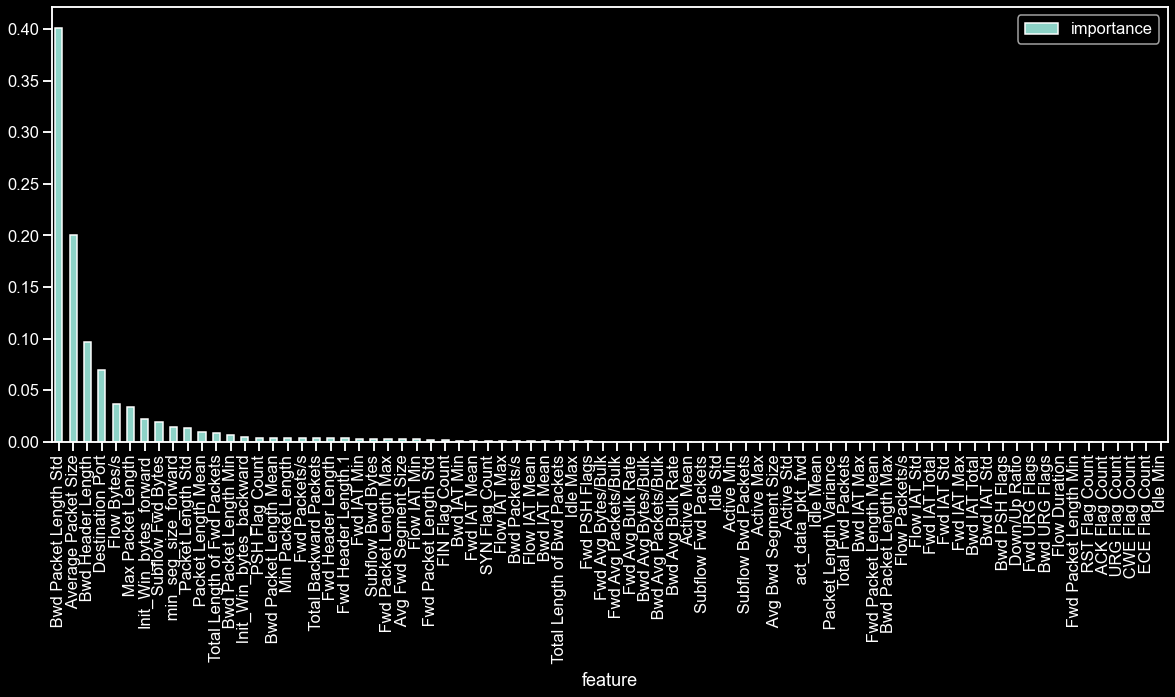

In [15]:
# Gradient Boosting - plot feature importance
score = np.round(gbc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_X.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (20,8)
importances.plot.bar()
plt.show()

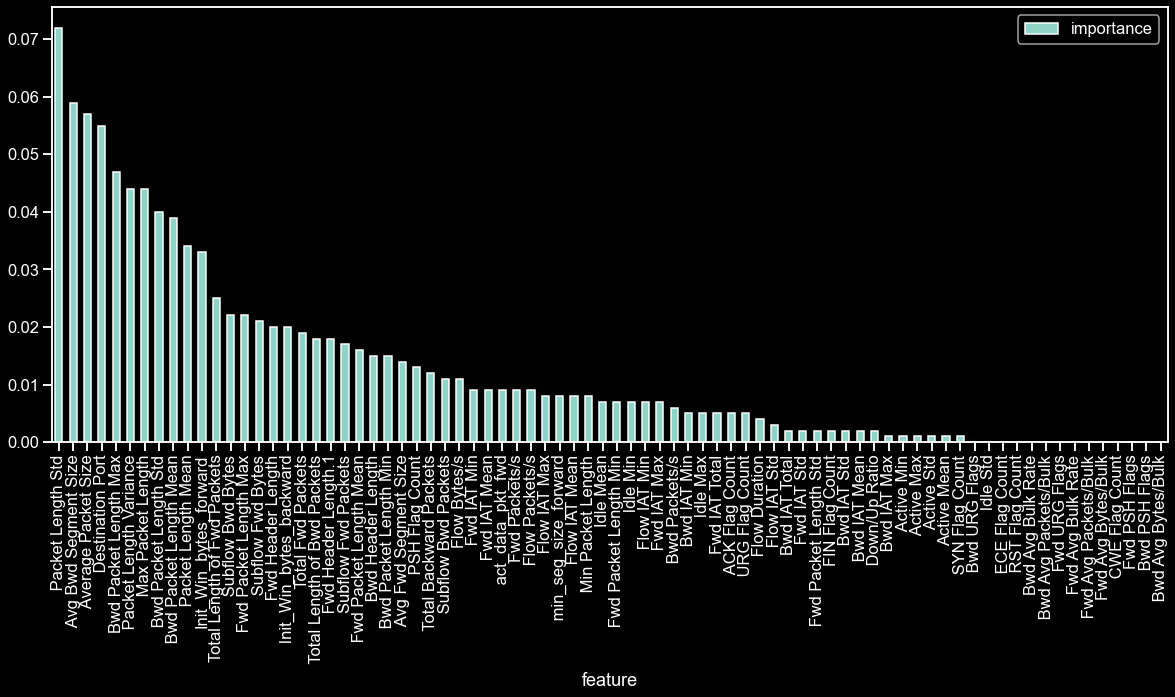

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_X.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (20, 8)
importances.plot.bar()
plt.show()

[10:11:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


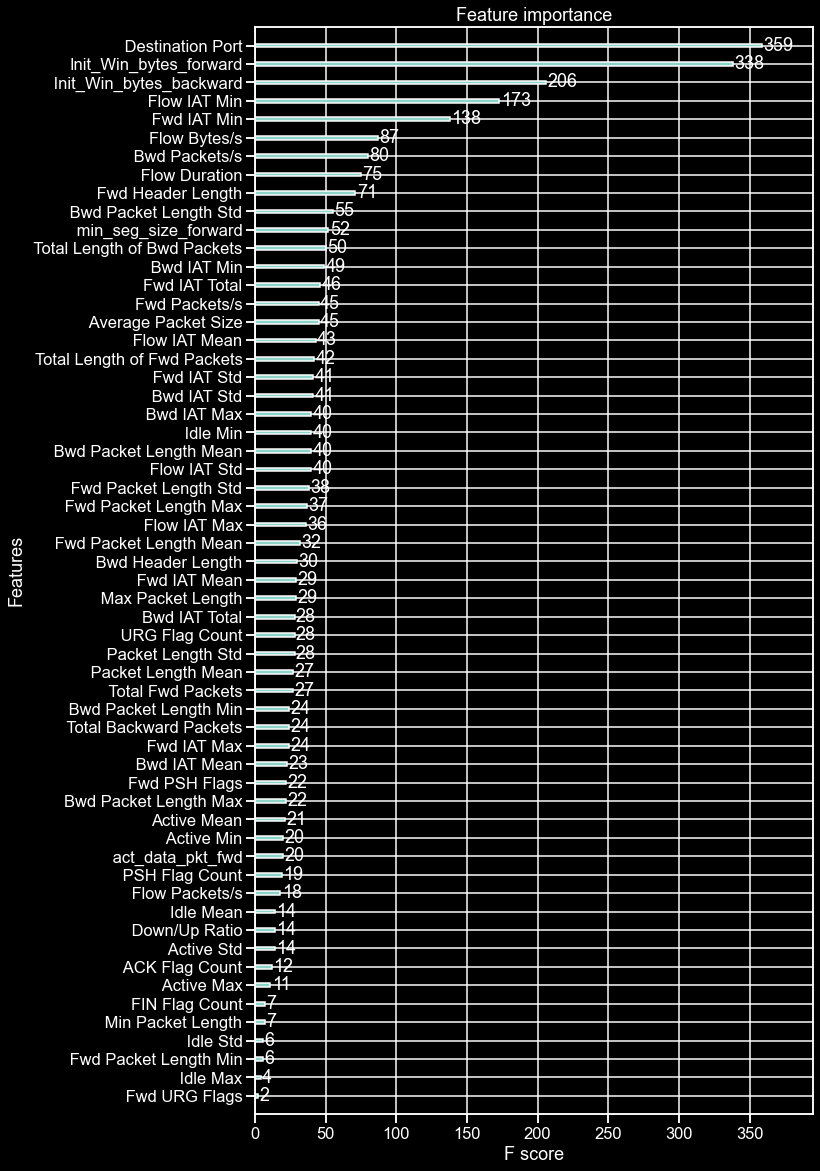

In [19]:
# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

xgb = XGBClassifier(random_state=42)
xgb_model = xgb.fit(train_X,train_y)

# plot feature importance
plt.rcParams['figure.figsize'] = (10,20)
plot_importance(xgb_model)
plt.show()

## Feature Selection - Wrapper
> RFE (Rercursive Feature Elimination)

In [20]:
from sklearn.feature_selection import RFE
import itertools

rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(train_X, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_X.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

a = [i[0] for i in feature_map]
train_X = train_X.iloc[:,a]
test_X = test_X.iloc[:,a]

KeyboardInterrupt: 

## Model Fitting & Evaluation

In [22]:
# Dataset Partition
X_train,X_test,Y_train,Y_test = train_test_split(train_X,train_y,train_size=0.70, random_state=2)

# Fitting Models
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

# Train Gradient Boosting Model
gbm = GradientBoostingClassifier()
gbm.fit(train_X,train_y)

# Train XGBoost Model
xgb = XGBClassifier(criterion='entropy', random_state=0)
xgb.fit(train_X,train_y)

# xgbpreds = xgb.predict(x_test)
# print("Accuracy",accuracy_score(y_test,xgbpreds))
# print(classification_report(y_test,xgbpreds))

[12:12:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:13:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='entropy',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [23]:
# Evaluate Models
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.8126956206306806

Model Accuracy:
 0.8127006716659727

Confusion matrix:
 [[131725 140761]
 [118772 994401]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.53      0.48      0.50    272486
         1.0       0.88      0.89      0.88   1113173

    accuracy                           0.81   1385659
   macro avg       0.70      0.69      0.69   1385659
weighted avg       0.81      0.81      0.81   1385659



============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9988316028894108

Model Accuracy:
 0.9998267972134558

Confusion matrix:
 [[ 272481       5]
 [    235 1112938]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    272486
         1.0      

KeyboardInterrupt: 

In [ ]:
# Validate Models
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()   

In [ ]:
# PREDICTING FOR TEST DATA
pred_knn = KNN_Classifier.predict(test_X)
pred_NB = BNB_Classifier.predict(test_X)
pred_log = LGR_Classifier.predict(test_X)
pred_dt = DTC_Classifier.predict(test_X)

## Check Assumptions
> classifier 또는 model을 사용하기전에 Assumption 확인

In [ ]:
# Test multicollinearity (VIF - Variance Inflation Factor)
# correlation matrix and scatter plots only show bivariate relationship b/w indep vars
# VIF shows correlation of a var with a group of other vars

# scatter plot 이나 correlation matrix으로도 multicollinearity를 확인할수있지만
# scatter plot 이나 correlation matrix는 각각의 변수들끼리의 상관관계를 측정하고
# VIF는 한변수와 다른 변수그룹의 상관관계를 측정해주어서 더 선호됨
# VIF 값이 10이상인 경우 high multicollinearity를 가짐

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

calc_vif(df_x)

------- Variables with High multicollinearity (multicollinearity exceeding 10) <br>
Flow IAT Mean <br>
Active Min <br>
Fwd IAT Mean <br>
Active Mean <br>
Bwd IAT Max <br>
Flow IAT Min <br>
Active Max	<br>
Active Std <br>

In [ ]:
## Logistic Regression assumptions <- (Cannot use)
# 1. data requires a large sample size to predict properly
# 2. data assumes the observations(X) to be independent of each other
# 3. data assumes that there is minimal or no multicollinearity among the independent variables(X)
#    - multicollinearity occurs when two or more indep vars are highly correlated with one another in reg model

## high multicollinearity를 가지고있는 feature 들이 많아서 이론적으로 Logistic Regression을 쓸수없음
# 목적이 predictor variables(X)가 response variable(Y)에 미치는 영향과 모델의 interpretability면 collinearity 가 중요하지만
# 목적이 모델의 예측능력(성능)인 경우 생략 가능하지만 항상 확인하는것이 좋음

# 특정 머신러닝 모델들은 interpretability (해석)이 불가능

# ----------etc

# svm drawbacks -> not suitable for large datasets and large noise data, 